In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [3]:
# Load IMDB title basics dataset (tab-separated, no compression)
imdb_data = pd.read_csv(
    "/content/title.basics.tsv",
    sep='\t',
    dtype={'isAdult': str},  # Force isAdult column to string type
    low_memory=False  # Suppress warning by processing in chunks
)
print("IMDB Data Sample:\n", imdb_data.head())

IMDB Data Sample:
       tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short            Poor Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

  isAdult startYear endYear runtimeMinutes                    genres  
0       0      1894      \N              1         Documentary,Short  
1       0      1892      \N              5           Animation,Short  
2       0      1892      \N              5  Animation,Comedy,Romance  
3       0      1892      \N             12           Animation,Short  
4       0      1893      \N              1                     Short  


In [2]:
# Load MovieLens movies dataset (comma-separated)
movielens_data = pd.read_csv('/content/movies.csv')
print("MovieLens Data Sample:\n", movielens_data.head())

MovieLens Data Sample:
    movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [4]:
imdb_data = imdb_data[['tconst', 'primaryTitle', 'genres']]

# Remove missing values
imdb_data = imdb_data.dropna()

# Remove duplicates based on title
imdb_data = imdb_data.drop_duplicates(subset='primaryTitle')

# Sample 10,000 rows for speed
imdb_data = imdb_data.sample(10000, random_state=42)

# Reset index
imdb_data = imdb_data.reset_index(drop=True)

print("Cleaned IMDB Data Shape:", imdb_data.shape)
print("Cleaned IMDB Data Sample:\n", imdb_data.head())

Cleaned IMDB Data Shape: (10000, 3)
Cleaned IMDB Data Sample:
        tconst                       primaryTitle           genres
0  tt29064138              Hamake Disha Mil Gail            Drama
1  tt33995113                   Beyond Triathlon      Documentary
2  tt28639138  Thanks for 1,500,000 Subscribers!  Animation,Short
3   tt7236010    Girl Next Door Likes It Dirty 7            Adult
4   tt0280497                     Bomb 'n Venice               \N


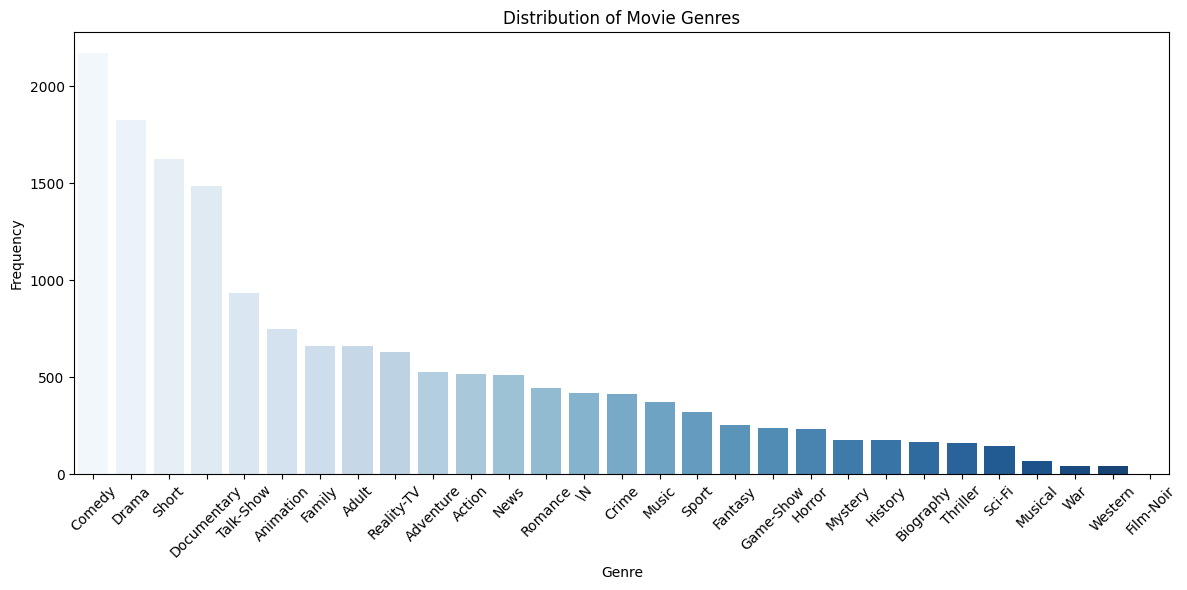

In [5]:
genres = imdb_data['genres'].str.split(',', expand=True).stack()

# Count genre occurrences
genre_counts = genres.value_counts()

# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, hue=genre_counts.index, palette='Blues', legend=False)
plt.title('Distribution of Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
imdb_data['text'] = imdb_data['primaryTitle'] + ' ' + imdb_data['genres']
print("Text features created")

# TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(imdb_data['text'])
print("TF-IDF done. Matrix Shape:", tfidf_matrix.shape)

# Cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print("Cosine similarity done. Matrix Shape:", cosine_sim.shape)

# SVD (100 components)
U, sigma, Vt = svds(cosine_sim, k=100)
sigma = np.diag(sigma)
reduced_sim = np.dot(np.dot(U, sigma), Vt)
print("SVD done. Reduced Matrix Shape:", reduced_sim.shape)

# Save files
!mkdir -p data
with open('data/similarity.pkl', 'wb') as f:
    pickle.dump(reduced_sim, f)
imdb_data.to_csv('data/cleaned_imdb_data.csv', index=False)
print("Files saved")

Text features created
TF-IDF done. Matrix Shape: (10000, 16592)
Cosine similarity done. Matrix Shape: (10000, 10000)
SVD done. Reduced Matrix Shape: (10000, 10000)
Files saved


In [11]:
def get_recommendations(movie_title, similarity_matrix, data, top_n=5):
    try:
        idx = data[data['primaryTitle'] == movie_title].index[0]
        sim_scores = similarity_matrix[idx]
        top_indices = sim_scores.argsort()[::-1][1:top_n+1]
        recommendations = data.iloc[top_indices][['primaryTitle', 'genres']].copy()
        recommendations['similarity_score'] = sim_scores[top_indices]
        return recommendations
    except IndexError:
        return "Movie not found!"

# Test with multiple movies
test_movies = imdb_data['primaryTitle'].sample(3, random_state=42).tolist()  # Pick 3 random movies
for movie in test_movies:
    print(f"\nRecommendations for '{movie}':")
    recs = get_recommendations(movie, reduced_sim, imdb_data)
    print(recs)

# Manual evaluation (example: rate recommendations as relevant [1] or not [0])
# Example ratings for first movie's recommendations
ratings = [1, 1, 0, 1, 1]  # Replace with your ratings after inspecting
precision = sum(ratings) / len(ratings)
print(f"\nExample Precision for '{test_movies[0]}': {precision*100:.2f}%")


Recommendations for 'Demencija i drustvo zaborava':
                       primaryTitle                       genres  \
7843                      Home-made                  Documentary   
7790  Argus Arcade Game Documentary                  Documentary   
6724                   Good as You?                  Documentary   
8488           Up for the Adventure  Biography,Documentary,Short   
961                 A Will to Dream                  Documentary   

      similarity_score  
7843          0.069690  
7790          0.069644  
6724          0.068086  
8488          0.066070  
961           0.065658  

Recommendations for 'Mrs. Ladybug':
        primaryTitle                   genres  similarity_score
3053  Twelve Forever  Animation,Comedy,Family          0.252924
1254  Sound Your 'A'  Animation,Comedy,Family          0.244161
1722  A Family Again   Adventure,Comedy,Drama          0.223171
9856         Árboles  Animation,Comedy,Family          0.220861
5740      Wörterklau  Animation